<a href="https://colab.research.google.com/github/raviintechis/Ravi_asian-vs-african-elephants-baseline/blob/main/Ravi_asian_vs_african_elephants_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
## imports 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D, SpatialDropout2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3, EfficientNetB3
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from PIL import Image

import os

In [17]:
print(tf.__version__)

2.7.0


##Shape and Batch size

In [18]:
NUM_TRAIN = 840
IMAGE_SIZE = (229, 229)
BATCH_SIZE = 64
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True)

In [22]:
train_directory = '/content/drive/ My Drive/Colab Notebooks/African_American/train'
train_files = []
for root, directories, files in os.walk(train_directory):
    for file in files:
        train_files.append(os.path.join(root, file))
print(len(train_files))

841


In [23]:
test_directory = '/content/drive/ My Drive/Colab Notebooks/African_American/test'
test_files = []
for root, directories, files in os.walk(test_directory):
    for file in files:
        test_files.append(os.path.join(root, file))
print(len(test_files))

189


In [24]:
train_ds = tf.keras.utils.image_dataset_from_directory(directory = train_directory,
                                                     labels = 'inferred',
                                                     label_mode = 'binary',
                                                     image_size = IMAGE_SIZE,
                                                     shuffle = True,
                                                     batch_size = BATCH_SIZE)
classes = train_ds.class_names
train_ds = train_ds.prefetch(1)

test_ds = tf.keras.utils.image_dataset_from_directory(directory = test_directory,
                                                    labels = 'inferred',
                                                    label_mode = 'binary',
                                                    image_size = IMAGE_SIZE,
                                                    batch_size = BATCH_SIZE)\
                        .prefetch(1)

Found 840 files belonging to 2 classes.
Found 188 files belonging to 2 classes.


In [25]:
AUGMENT_LAYER = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

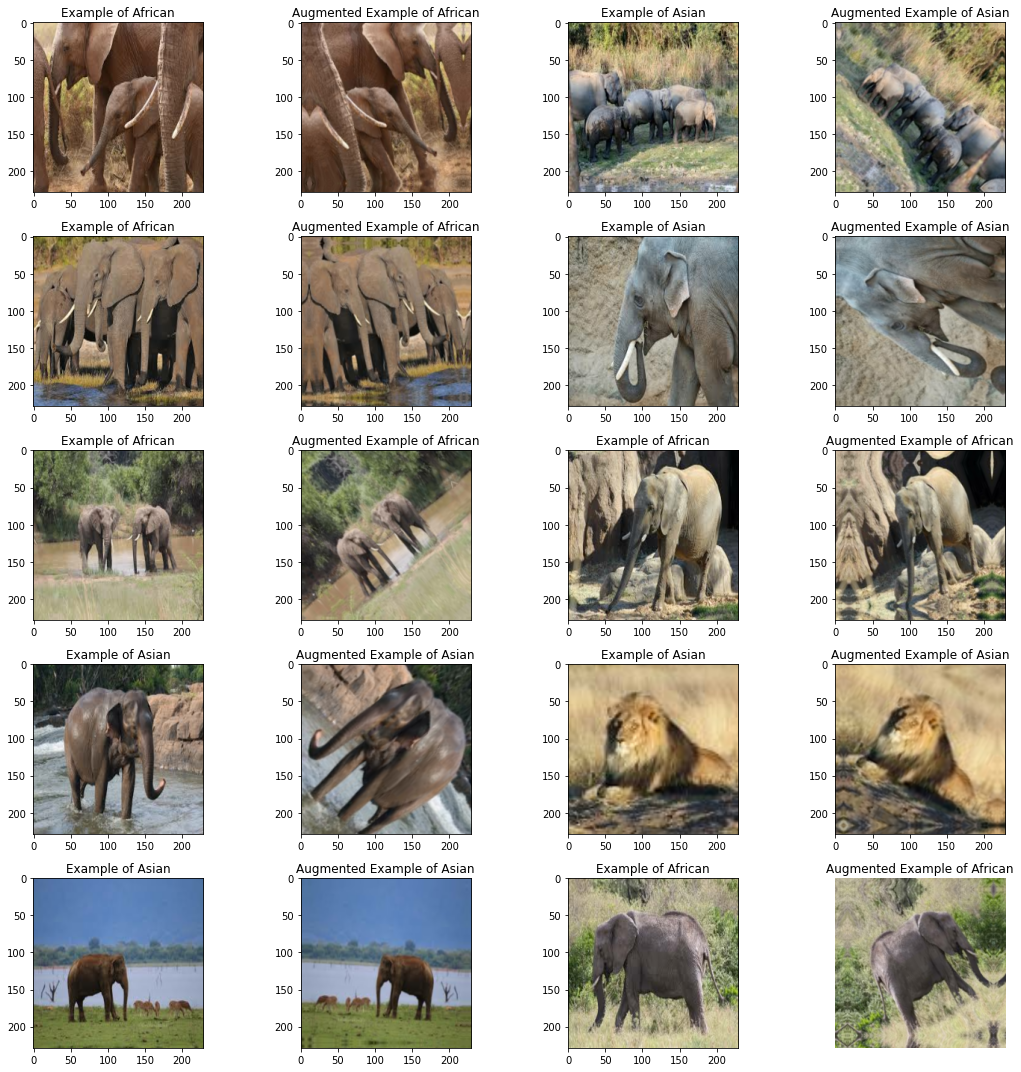

In [26]:
fig, axes = plt.subplots(5, 4, figsize = (15, 15))
axes = axes.flatten()
images_to_show = next(iter(train_ds))
for i in range(10):
    img = images_to_show[0]
    img = img[i] / 255
    lbl = images_to_show[1]
    lbl = lbl.numpy().astype(int).reshape(-1)
    lbl = lbl[i]
    lbl = classes[lbl]
    aug_img = AUGMENT_LAYER(img)
    axes[2 * i].imshow(img)
    axes[2 * i + 1].imshow(aug_img)
    axes[2 * i].set_title(f'Example of {lbl}')
    axes[2 * i + 1].set_title(f'Augmented Example of {lbl}')
    plt.axis('off')
    
plt.tight_layout()

In [27]:
def build_model():
    inp = Input(shape = (*IMAGE_SIZE, 3))
    x = inp
    x = AUGMENT_LAYER(x)
    base_model = InceptionV3(weights = 'imagenet',
                            include_top = False,
                            input_tensor = x)
    
    head_model = base_model.output
    head_model = Flatten()(head_model)
    head_model = Dropout(rate = 0.50)(head_model)
    head_model = Dense(units = 128, activation = 'relu')(head_model)
    
    head_model = Dense(units = 1, activation = 'sigmoid')(head_model)
    
    #inp = base_model.input
    return Model(inputs = inp, outputs = head_model)

In [28]:
model = build_model()

model.compile(optimizer = Adam(learning_rate = 6*10**-5), loss = 'binary_crossentropy', metrics = ['accuracy'])
hist = model.fit(train_ds, validation_data = test_ds, epochs = 50, callbacks = [early_stopping])

87924736/87910968 [==============================] - 1s 0us/step
Epoch 1/50
14/14 [==============================] - 493s 35s/step - loss: 0.8632 - accuracy: 0.5000 - val_loss: 0.7737 - val_accuracy: 0.5106
Epoch 2/50
14/14 [==============================] - 431s 31s/step - loss: 0.6818 - accuracy: 0.5583 - val_loss: 0.6876 - val_accuracy: 0.5213
Epoch 3/50
14/14 [==============================] - 427s 30s/step - loss: 0.6449 - accuracy: 0.6131 - val_loss: 0.6259 - val_accuracy: 0.6649
Epoch 4/50
14/14 [==============================] - 432s 31s/step - loss: 0.5957 - accuracy: 0.6679 - val_loss: 0.5578 - val_accuracy: 0.7287
Epoch 5/50
14/14 [==============================] - 432s 31s/step - loss: 0.5847 - accuracy: 0.6940 - val_loss: 0.5604 - val_accuracy: 0.7287
Epoch 6/50
14/14 [==============================] - 430s 31s/step - loss: 0.5300 - accuracy: 0.7369 - val_loss: 0.5028 - val_accuracy: 0.7660
Epoch 7/50
14/14 [==============================] - 428s 30s/step - loss: 0.5112 - 

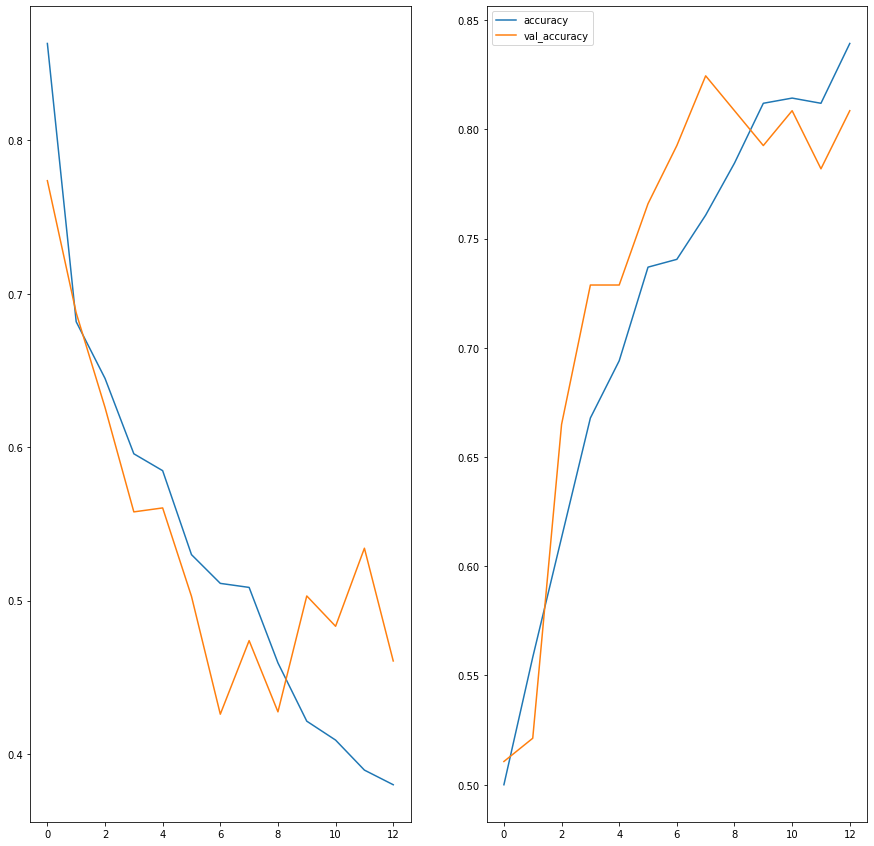

In [29]:
fig, axes = plt.subplots(1, 2, figsize = (15, 15))
axes = axes.flatten()
hist.history.keys()
loss = hist.history['loss']
val_loss = hist.history['val_loss']
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(len(loss))
axes[0].plot(epochs, loss, label = 'loss')
axes[0].plot(epochs, val_loss, label = 'val_loss')
axes[1].plot(epochs, acc, label = 'accuracy')
axes[1].plot(epochs, val_acc, label = 'val_accuracy')
plt.legend()

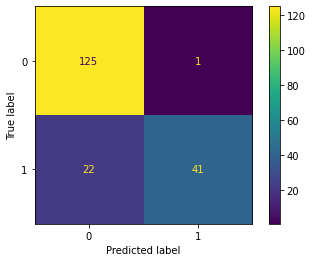

In [35]:
predictions = np.zeros(len(test_files))
true = np.zeros(len(test_files))
for idx, batch in test_ds.enumerate():
    images = batch[0]
    labels = batch[1].numpy().reshape(-1)
    preds = model.predict(images).reshape(-1)
    
    if len(preds) == BATCH_SIZE:
        predictions[BATCH_SIZE * idx : BATCH_SIZE * (idx + 1)] = preds
        true[BATCH_SIZE * idx : BATCH_SIZE * (idx + 1)] = labels
   # else:
        #predictions[BATCH_SIZE * idx:] = preds
       # true[BATCH_SIZE * idx:] = labels

predictions[predictions < 0.5] = 0
predictions[predictions >= 0.5] = 1
cm = confusion_matrix(y_true = true, y_pred = predictions)
cmd = ConfusionMatrixDisplay(confusion_matrix = cm)
cmd.plot()

In [36]:
print('Accuracy :',round(max(acc)*100,2),'%')

Accuracy : 83.93 %
